<a href="https://colab.research.google.com/github/dsfsgroup4/customer-sentiment-analysis/blob/main/mcdo_mg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
import re #pour regex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#librairies pour model SentimentIntensityAnalyser
import nltk
from nltk.corpus import stopwords #utilisé pour la tokenisation
from nltk.sentiment import SentimentIntensityAnalyzer #le model utilisé
from nltk.tokenize import word_tokenize #le tokenizer
from collections import Counter #pour word count

from wordcloud import WordCloud # éventuellement utile pour visualiser les top thématiques

from transformers import pipeline #pour model DistilBERT

nltk.download('vader_lexicon') #model utilisé
nltk.download('stopwords') #pour tokenisation
nltk.download('punkt_tab') #nécessaire pour la tokenisation


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [128]:
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')
!ls '/content/drive/My Drive/Colab Notebooks/Jedha/Projet/McDonald_s_Reviews.csv'
path = "/content/drive/My Drive/Colab Notebooks/Jedha/Projet/McDonald_s_Reviews.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'/content/drive/My Drive/Colab Notebooks/Jedha/Projet/McDonald_s_Reviews.csv'


In [129]:
df = pd.read_csv(path, encoding='latin-1')



# Découverte du Dataset:

In [130]:
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [131]:
df.review[0] #premier commentaire évalué 1 étoile mais attribué positif par le SentimentIntensityAnalyser

'Why does it look like someone spit on my food?\nI had a normal transaction,  everyone was chill and polite, but now i dont want to eat this. Im trying not to think about what this milky white/clear substance is all over my food, i d*** sure am not coming back.'

In [132]:
df.describe(include = "all")
#On constate que des données de latitude et longitude sont manquantes

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
count,33396.000000,33396,33396,33396,32736.000000,32736.000000,33396,33396,33396,33396
unique,NaN,2,1,40,NaN,NaN,51,39,22285,5
top,NaN,McDonald's,Fast food restaurant,"9814 International Dr, Orlando, FL 32819, Unit...",NaN,NaN,"2,193",4 years ago,Excellent,5 stars
freq,NaN,33325,33396,1890,NaN,NaN,1140,6740,2148,10274
mean,16698.500000,NaN,NaN,NaN,34.442546,-90.647033,NaN,NaN,NaN,NaN
std,9640.739131,NaN,NaN,NaN,5.344116,16.594844,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,25.790295,-121.995421,NaN,NaN,NaN,NaN
25%,8349.750000,NaN,NaN,NaN,28.655350,-97.792874,NaN,NaN,NaN,NaN
50%,16698.500000,NaN,NaN,NaN,33.931261,-81.471414,NaN,NaN,NaN,NaN
75%,25047.250000,NaN,NaN,NaN,40.727401,-75.399919,NaN,NaN,NaN,NaN


In [133]:
df[df.isnull().any(axis = 1)].head(3)
#les valeurs longitudes et latitudes manquantes ont également des adresses incorrectes. il faudra donc les supprimer

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
22141,22142,McDonald's,Fast food restaurant,2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,NaN,NaN,"2,175",3 months ago,Breakfast specials are good. The sausage burri...,4 stars
22142,22143,McDonald's,Fast food restaurant,2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,NaN,NaN,"2,175",a year ago,This isn't your typical McDonald's. This place...,5 stars
22143,22144,McDonald's,Fast food restaurant,2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,NaN,NaN,"2,175",2 weeks ago,This place was serving good quality breakfast ...,4 stars


In [134]:
df.store_name.value_counts()
#pas de distinction notable sur les les store_name

,count
store_name,
McDonald's,33325
ýýýMcDonald's,71


In [135]:
df[df.store_name=="ýýýMcDonald's"]

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
500,501,ýýýMcDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 years ago,Tasty as usual,5 stars
1000,1001,ýýýMcDonald's,Fast food restaurant,"1698 US-209, Brodheadsville, PA 18322, United ...",40.922081,-75.399919,"1,028",2 years ago,It was good food they got my burger right !!,4 stars
1500,1501,ýýýMcDonald's,Fast food restaurant,"1698 US-209, Brodheadsville, PA 18322, United ...",40.922081,-75.399919,"1,028",4 years ago,Excellent,5 stars
2000,2001,ýýýMcDonald's,Fast food restaurant,"72-69 Kissena Blvd, Queens, NY 11367, United S...",40.727401,-73.812460,"2,193",4 years ago,I never ever ever complain but I've had enough...,1 star
2500,2501,ýýýMcDonald's,Fast food restaurant,"72-69 Kissena Blvd, Queens, NY 11367, United S...",40.727401,-73.812460,"2,193",4 years ago,Fast worker give them props,4 stars
...,...,...,...,...,...,...,...,...,...,...
31255,31256,ýýýMcDonald's,Fast food restaurant,"632 S R L Thornton Freeway Service Rd, Dallas,...",32.744596,-96.812286,"2,658",2 years ago,"Same ol"" ready in 2 minutes food. Idk how they...",2 stars
31755,31756,ýýýMcDonald's,Fast food restaurant,"632 S R L Thornton Freeway Service Rd, Dallas,...",32.744596,-96.812286,"2,658",2 years ago,Unique decor. Bad part of town.,3 stars
32255,32256,ýýýMcDonald's,Fast food restaurant,"632 S R L Thornton Freeway Service Rd, Dallas,...",32.744596,-96.812286,"2,658",2 years ago,ýýýýýýýý Terrible service... they never give y...,1 star
32755,32756,ýýýMcDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",5 years ago,They told to wait 7 mnts then she said we are ...,1 star


In [136]:
df.review.sort_values(ascending=False)

,review
6163,ýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýý...
29362,ýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýý
4898,ýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýý ýýý
15018,ýýýýýýýýýýýýýýýýýýýýý
12379,ýýýýýýýýýýýýýýýýýýýý ýýý
...,...
21773,"""24 hour"" store that is closed...."
7110,"!! Fraud location !! !!!Fraud location !!!, th..."
700,waiting time was longer than expected
661,waiting time was longer than expected


# Cleaning

In [137]:
caracteres_speciaux = ["½ï","ý"]
# Créer une expression régulière à partir de la liste
regex_pattern = '|'.join(caracteres_speciaux)

# Filtrer les lignes contenant l'un des caractères spéciaux
filtered_df = df['review'].str.contains(regex_pattern, na=False)

inverted_filtered_df = ~filtered_df #création d'un mask qui ne conserve que les lignes sans caractères spéciaux

In [138]:
df1 = df.copy()

In [139]:
#suppression des lignes avec caractères spéciaux
df1 = df1[inverted_filtered_df]

In [140]:
df1 = df1.dropna() #retirer les lignes sans latitude / longitude car leur adresse est invalide

In [141]:
# Drop columns 'reviewer_id', 'store_name', 'category'
df1 = df1.drop(columns=['reviewer_id','store_name', 'category'])


In [142]:
df1[['City', 'State']] = df1['store_address'].apply(lambda x: pd.Series(x.split(', ')[-3:-1]))



In [143]:
df1["rating"] = (df1["rating"].str.split(" ").str[0].astype(int))


In [144]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def parse_relative_date(s, current_date):
    # Remove extra whitespace and split the string
    parts = s.strip().split()
    if len(parts) != 3:
        return None
    # Check if the number is represented as "a" or "an"
    num_str = parts[0].lower()
    if num_str in ['a', 'an']:
        num = 1
    else:
        try:
            num = int(num_str)
        except ValueError:
            return None

    unit = parts[1].lower()

    # Adjust the current date based on the unit
    if 'day' in unit:
        abs_date = current_date - pd.Timedelta(days=num)
    elif 'month' in unit:
        abs_date = current_date - relativedelta(months=num)
    elif 'year' in unit:
        abs_date = current_date - relativedelta(years=num)
    else:
        return None

    # Normalize to remove the time (sets time to 00:00:00)
    return abs_date.normalize()

#Get the current date
current_date = pd.Timestamp.now()

#Apply the function to create a new column with the actual dates
df1['review_date'] = df1['review_time'].apply(lambda x: parse_relative_date(x, current_date))


In [145]:
def clean_review(review):
    review = review.lower()
    review = re.sub(r'[^a-zA-Z\s]', '', review) # retirer les caractères spéciaux
    review = re.sub(r'\s+', ' ', review).strip() # retirer les espaces
    review = re.sub(r'http\S+|www\S+', '', review) # retirer les URLs

    stop_words = set(stopwords.words('english'))
    review_tokens = nltk.word_tokenize(review) #methode de tokenisation efficace pour le langage courant (contractions de mots, ponctuation...)
    mot_a_sup = ["mcdonalds", "one"] #mots trop fréquents dans les commentaires
    stop_words.update(mot_a_sup)
    review = ' '.join([word for word in review_tokens if word not in stop_words])


    return review

df1['clean_reviews'] = df1['review'].apply(clean_review)


In [146]:
def liked (data):
    if data['rating'] > 3:
      return "POSITIF"
    elif data["rating"] ==3:
      return "NEUTRE"
    else:
      return "NEGATIF"

df1['liked'] = df1.apply(liked, axis = 1)


In [147]:
df1.head()

,store_address,latitude,longitude,rating_count,review_time,review,rating,City,State,review_date,clean_reviews,liked
0,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1,Austin,TX 78750,2025-01-02,look like someone spit food normal transaction...,NEGATIF
1,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4,Austin,TX 78750,2025-03-28,itd far food atmosphere go staff make differen...,POSITIF
4,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1,Austin,TX 78750,2025-02-02,repeat order times drive thru still manage mes...,NEGATIF
5,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 weeks ago,I work for door dash and they locked us all ou...,1,Austin,TX 78750,NaT,work door dash locked us wait long line reason...,NEGATIF
6,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,If I could give this location a zero on custo...,1,Austin,TX 78750,2025-01-02,could give location zero customer service woul...,NEGATIF


In [148]:
df1.describe(include="all")

,store_address,latitude,longitude,rating_count,review_time,review,rating,City,State,review_date,clean_reviews,liked
count,29794,29794.000000,29794.000000,29794,29794,29794,29794.000000,29794,29794,29452,29794,29794
unique,39,NaN,NaN,50,37,19384,NaN,26,36,NaN,18291,3
top,"9814 International Dr, Orlando, FL 32819, Unit...",NaN,NaN,"2,052",4 years ago,Excellent,NaN,New York,FL 32819,NaN,excellent,POSITIF
freq,1631,NaN,NaN,1099,6219,2148,NaN,3261,1993,NaN,2178,14756
mean,NaN,34.569618,-90.680862,NaN,NaN,NaN,3.196281,NaN,NaN,2022-04-17 01:45:04.278147584,NaN,NaN
min,NaN,25.790295,-121.995421,NaN,NaN,NaN,1.000000,NaN,NaN,2013-04-02 00:00:00,NaN,NaN
25%,NaN,28.655350,-97.792874,NaN,NaN,NaN,1.000000,NaN,NaN,2021-04-02 00:00:00,NaN,NaN
50%,NaN,34.012219,-81.471414,NaN,NaN,NaN,3.000000,NaN,NaN,2022-04-02 00:00:00,NaN,NaN
75%,NaN,40.727401,-75.399919,NaN,NaN,NaN,5.000000,NaN,NaN,2024-04-02 00:00:00,NaN,NaN
max,NaN,44.981410,-73.459820,NaN,NaN,NaN,5.000000,NaN,NaN,2025-04-01 00:00:00,NaN,NaN


In [149]:
df1.to_csv("/content/drive/My Drive/Colab Notebooks/Jedha/Projet/df1_cleanning.csv", index=False)

# EDA

In [150]:
df1["liked"].value_counts(normalize=True, dropna=False) * 100

,proportion
liked,
POSITIF,49.526750
NEGATIF,35.362825
NEUTRE,15.110425


In [151]:
df1["rating"].value_counts(normalize=True, dropna=False) * 100

,proportion
rating,
5,31.489562
1,26.025374
4,18.037189
3,15.110425
2,9.337450


In [152]:
df1["City"].value_counts(normalize=True, dropna=False) * 100

,proportion
City,
New York,10.945157
Orlando,8.854132
Austin,5.319863
North Hollywood,5.269517
Fern Park,5.269517
Kissimmee,5.054709
Dallas,5.027858
Miami,4.474055
Newark,3.873263


In [153]:
df1["State"].value_counts(normalize=True, dropna=False) * 100

,proportion
State,
FL 32819,6.689266
NY 10001,6.481171
CA 91602,5.269517
FL 32730,5.269517
FL 34746,5.054709
TX 75203,5.027858
FL 33137,4.474055
NJ 07104,3.873263
TX 76262,3.712157


# Sentiment analyser

In [180]:
df2 = df1.copy()

## model SentimentIntensityAnalyser

In [181]:
analyzer = SentimentIntensityAnalyzer()

#Sentiment score compris entre -1 (très négatif) et 1 (très positif)
df2['sentiment_score_SIA'] = df2['clean_reviews'].apply(lambda text: analyzer.polarity_scores(text)['compound'])
df2['sentiment_SIA'] = None

df2['sentiment_SIA'] = df2['sentiment_score_SIA'].apply(lambda score: 'positive' if score >= 0.4 else ('negative' if score <= -0.1 else 'neutral'))
print(df2[['sentiment_score_SIA', 'sentiment_SIA', 'liked']].head())

   sentiment_score_SIA sentiment_SIA    liked
0               0.5541      positive  NEGATIF
1               0.8591      positive  POSITIF
4              -0.7184      negative  NEGATIF
5              -0.2960      negative  NEGATIF
6              -0.5667      negative  NEGATIF


In [182]:
df2["sentiment_SIA"].value_counts(normalize=True, dropna=False) * 100

,proportion
sentiment_SIA,
positive,47.912331
neutral,28.458750
negative,23.628919


In [183]:
#rappel de la répartition des liked pour comparaison
df2["liked"].value_counts(normalize=True, dropna=False) * 100

,proportion
liked,
POSITIF,49.526750
NEGATIF,35.362825
NEUTRE,15.110425


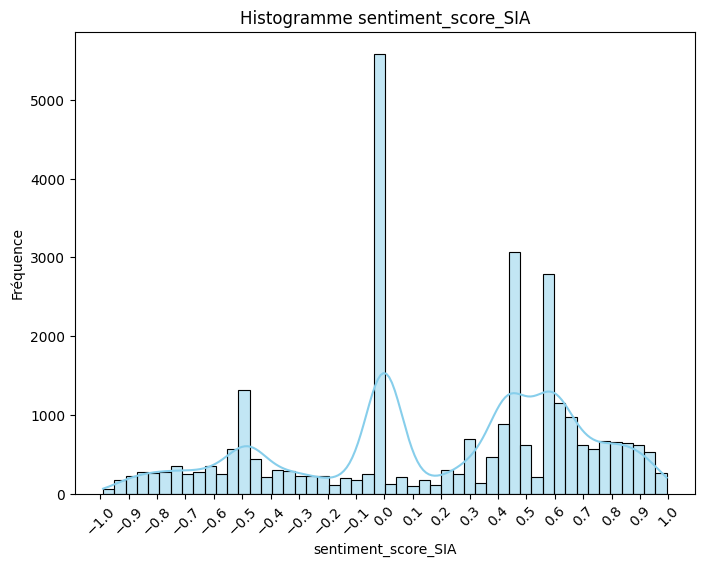

In [184]:
plt.figure(figsize=(8, 6))
sns.histplot(df2["sentiment_score_SIA"], bins=50, kde=True, color='skyblue', edgecolor='black')

plt.xlabel('sentiment_score_SIA')
plt.ylabel('Fréquence')
plt.title('Histogramme sentiment_score_SIA')

plt.xticks(rotation=45)  # Fait pivoter les étiquettes de 45 degrés
plt.xticks(np.arange(-1, 1.1, 0.1))  # Ajoute des graduations tous les 0.1 entre -1 et 1

# Afficher l'histogramme
plt.show()

<Figure size 800x600 with 0 Axes>

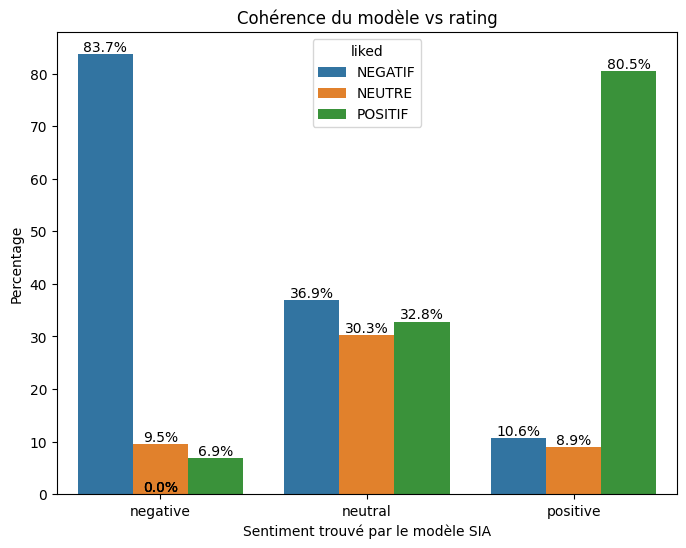

In [185]:
plt.figure(figsize=(8, 6))

# Calculer les pourcentages
rates = df2.groupby(['sentiment_SIA', 'liked']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100

# Convertir les taux en format long pour seaborn
rates_long = rates.reset_index().melt(id_vars='sentiment_SIA', value_name='percentage')

# Créer le diagramme en bâtons avec seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='sentiment_SIA', y='percentage', hue='liked')

# Ajouter des annotations
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')


# Ajouter un titre et des labels
plt.title('Cohérence du modèle vs rating')
plt.xlabel('Sentiment trouvé par le modèle SIA')
plt.ylabel('Percentage')
plt.xticks(rotation=0)

# Afficher le graphique
plt.show()



In [186]:
analyzer = SentimentIntensityAnalyzer() #model sans neutres

#Sentiment score compris entre -1 (très négatif) et 1 (très positif)
df2['sentiment_SIA_sans_neutre'] = df2['sentiment_score_SIA'].apply(lambda score: 'positive' if score >= 0.4 else 'negative')
print(df2[['sentiment_score_SIA', 'sentiment_SIA_sans_neutre', 'liked']].head())

   sentiment_score_SIA sentiment_SIA_sans_neutre    liked
0               0.5541                  positive  NEGATIF
1               0.8591                  positive  POSITIF
4              -0.7184                  negative  NEGATIF
5              -0.2960                  negative  NEGATIF
6              -0.5667                  negative  NEGATIF


<Figure size 800x600 with 0 Axes>

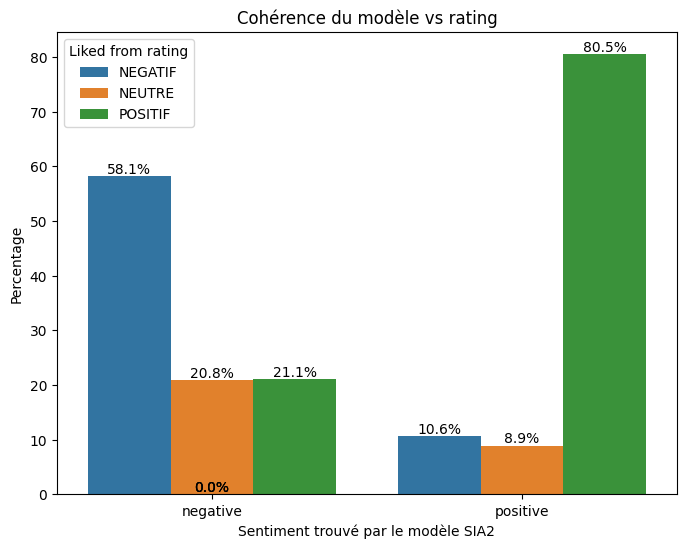

In [200]:
plt.figure(figsize=(8, 6))

# Calculer les pourcentages
rates = df2.groupby(['sentiment_SIA_sans_neutre', 'liked']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100

# Convertir les taux en format long pour seaborn
rates_long = rates.reset_index().melt(id_vars='sentiment_SIA_sans_neutre', value_name='percentage')

# Créer le diagramme en bâtons avec seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='sentiment_SIA_sans_neutre', y='percentage', hue='liked')

# Ajouter des annotations
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

# Ajouter un titre et des labels
plt.title('Cohérence du modèle vs rating')
plt.xlabel('Sentiment trouvé par le modèle SIA2')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Liked from rating')

# Afficher le graphique
plt.show()

In [188]:
df2

,store_address,latitude,longitude,rating_count,review_time,review,rating,City,State,review_date,clean_reviews,liked,sentiment_score_SIA,sentiment_SIA,sentiment_SIA_sans_neutre
0,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1,Austin,TX 78750,2025-01-02,look like someone spit food normal transaction...,NEGATIF,0.5541,positive,positive
1,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4,Austin,TX 78750,2025-03-28,itd far food atmosphere go staff make differen...,POSITIF,0.8591,positive,positive
4,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1,Austin,TX 78750,2025-02-02,repeat order times drive thru still manage mes...,NEGATIF,-0.7184,negative,negative
5,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 weeks ago,I work for door dash and they locked us all ou...,1,Austin,TX 78750,NaT,work door dash locked us wait long line reason...,NEGATIF,-0.2960,negative,negative
6,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,If I could give this location a zero on custo...,1,Austin,TX 78750,2025-01-02,could give location zero customer service woul...,NEGATIF,-0.5667,negative,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33391,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",4 years ago,They treated me very badly.,1,Miami,FL 33137,2021-04-02,treated badly,NEGATIF,-0.4767,negative,negative
33392,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",a year ago,The service is very good,5,Miami,FL 33137,2024-04-02,service good,POSITIF,0.4404,positive,positive
33393,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",a year ago,To remove hunger is enough,4,Miami,FL 33137,2024-04-02,remove hunger enough,POSITIF,-0.2500,negative,negative
33394,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",5 years ago,"It's good, but lately it has become very expen...",5,Miami,FL 33137,2020-04-02,good lately become expensive,POSITIF,0.4404,positive,positive


In [189]:
df2.to_csv("/content/drive/My Drive/Colab Notebooks/Jedha/Projet/df2_model_SIA.csv", index=False)

## Model Text_classification from DistilBERT

In [190]:
#le model est trop gros pour être testé sur les 33000 lignes du dataset. nous le testons donc sur un sample de 3500
df2_sample=df2[df2["City"]=="New York"]

<Figure size 800x600 with 0 Axes>

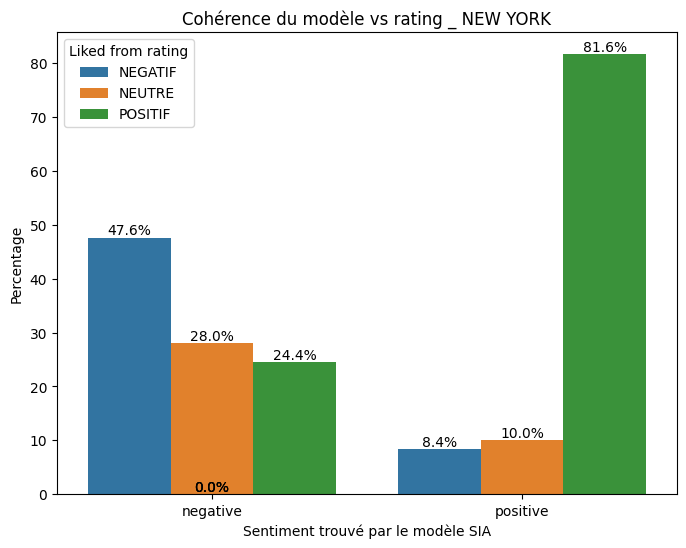

In [201]:
# Rappel résultats du model SIA sans neutre filtré sur NY
plt.figure(figsize=(8, 6))

# Calculer les pourcentages
rates = df2_sample.groupby(['sentiment_SIA_sans_neutre', 'liked']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100

# Convertir les taux en format long pour seaborn
rates_long = rates.reset_index().melt(id_vars='sentiment_SIA_sans_neutre', value_name='percentage')

# Créer le diagramme en bâtons avec seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='sentiment_SIA_sans_neutre', y='percentage', hue='liked')

# Ajouter des annotations
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

# Ajouter un titre et des labels
plt.title('Cohérence du modèle vs rating _ NEW YORK')
plt.xlabel('Sentiment trouvé par le modèle SIA')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Liked from rating')

# Afficher le graphique
plt.show()

<Figure size 800x600 with 0 Axes>

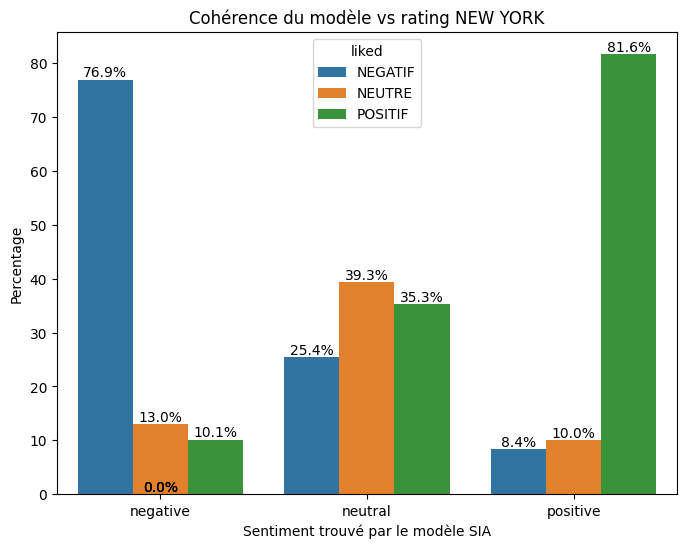

In [202]:
# Rappel résultats du model SIA filtré sur NY
plt.figure(figsize=(8, 6))

# Calculer les pourcentages
rates = df2_sample.groupby(['sentiment_SIA', 'liked']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100

# Convertir les taux en format long pour seaborn
rates_long = rates.reset_index().melt(id_vars='sentiment_SIA', value_name='percentage')

# Créer le diagramme en bâtons avec seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='sentiment_SIA', y='percentage', hue='liked')

# Ajouter des annotations
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

# Ajouter un titre et des labels
plt.title('Cohérence du modèle vs rating NEW YORK')
plt.xlabel('Sentiment trouvé par le modèle SIA')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Liked from rating')

# Afficher le graphique
plt.show()

In [197]:
#test du model distilbert
pipe = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english", truncation=True, max_length=512) #model par défaut. tronqué car il ne support pas les reviews de plus de 512 tokens
reviews = df2_sample["review"].tolist()
df2_sample['text_classification'] = pipe(reviews)

Device set to use cpu
<ipython-input-197-1c83b4f53357>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_sample['text_classification'] = pipe(reviews)


In [198]:
for i in df2_sample.index:
    df2_sample.loc[i, "sentiment_TC"] = df2_sample.loc[i, "text_classification"]["label"]
    df2_sample.loc[i, "score_TC"] = df2_sample.loc[i, "text_classification"]["score"]
df2_sample.drop(["text_classification"],axis = 1)

<ipython-input-198-d3d346ec8df5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_sample.loc[i, "sentiment_TC"] = df2_sample.loc[i, "text_classification"]["label"]
<ipython-input-198-d3d346ec8df5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_sample.loc[i, "score_TC"] = df2_sample.loc[i, "text_classification"]["score"]


,store_address,latitude,longitude,rating_count,review_time,review,rating,City,State,review_date,clean_reviews,liked,sentiment_score_SIA,sentiment_SIA,sentiment_SIA_sans_neutre,sentiment_TC,score_TC
2968,"429 7th Ave, New York, NY 10001, United States",40.750506,-73.990583,"2,052",a year ago,Visited this location for breakfast. The place...,3,New York,NY 10001,2024-04-02,visited location breakfast place small better ...,NEUTRE,0.9015,positive,positive,POSITIVE,0.986821
2969,"429 7th Ave, New York, NY 10001, United States",40.750506,-73.990583,"2,052",a year ago,From cleanliness to freshness to the fast cust...,5,New York,NY 10001,2024-04-02,cleanliness freshness fast customer service st...,POSITIF,0.7579,positive,positive,POSITIVE,0.996774
2970,"429 7th Ave, New York, NY 10001, United States",40.750506,-73.990583,"2,052",3 months ago,McDonalds was great! The food tastes like in U...,5,New York,NY 10001,2025-01-02,great food tastes like ukraine europe fried po...,POSITIF,0.8860,positive,positive,NEGATIVE,0.992124
2974,"429 7th Ave, New York, NY 10001, United States",40.750506,-73.990583,"2,052",2 weeks ago,"Can't complain, I love the grab and go style a...",4,New York,NY 10001,NaT,cant complain love grab go style im looking ca...,POSITIF,-0.3089,negative,negative,POSITIVE,0.999521
2975,"429 7th Ave, New York, NY 10001, United States",40.750506,-73.990583,"2,052",a month ago,Came here at 430a... thought it was supposed t...,2,New York,NY 10001,2025-03-02,came thought supposed open hours saw mcd emplo...,NEGATIF,-0.1027,negative,negative,NEGATIVE,0.999620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10085,"151 West 34th Street (Macy's 7th Floor, New Yo...",40.750831,-73.989096,263,6 years ago,The cashiers are very nice and the place is co...,5,New York,NY 10001,2019-04-02,cashiers nice place comfortable great place in...,POSITIF,0.8807,positive,positive,POSITIVE,0.999825
10086,"151 West 34th Street (Macy's 7th Floor, New Yo...",40.750831,-73.989096,263,3 years ago,The security will kick you out if you don't fi...,2,New York,NY 10001,2022-04-02,security kick dont finish food mins sooo shock...,NEGATIF,0.0258,neutral,negative,NEGATIVE,0.970577
10087,"151 West 34th Street (Macy's 7th Floor, New Yo...",40.750831,-73.989096,263,5 years ago,"Fast service, although the table service which...",3,New York,NY 10001,2020-04-02,fast service although table service supposed w...,NEUTRE,-0.3720,negative,negative,POSITIVE,0.999618
10088,"151 West 34th Street (Macy's 7th Floor, New Yo...",40.750831,-73.989096,263,3 years ago,To avoid ! Restaurant room very small. Sad for...,1,New York,NY 10001,2022-04-02,avoid restaurant room small sad store floors e...,NEGATIF,-0.2732,negative,negative,NEGATIVE,0.999788


<Figure size 800x600 with 0 Axes>

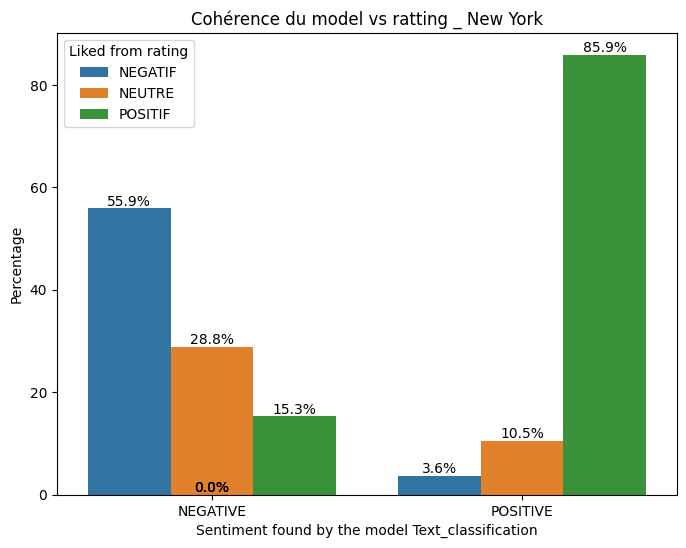

In [203]:
plt.figure(figsize=(8, 6))

# Calculer les pourcentages
rates = df2_sample.groupby(['sentiment_TC', 'liked']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100

# Convertir les taux en format long pour seaborn
rates_long = rates.reset_index().melt(id_vars='sentiment_TC', value_name='percentage')

# Créer le diagramme en bâtons avec seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='sentiment_TC', y='percentage', hue='liked')

# Ajouter des annotations
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.title('Cohérence du model vs ratting _ New York')
plt.xlabel('Sentiment found by the model Text_classification')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Liked from rating')
plt.show()

Une meilleure attribution des positif, mais davantage de faux négatifs

In [206]:
df2_sample.to_csv("/content/drive/My Drive/Colab Notebooks/Jedha/Projet/df2_sample_model_DistilBERT.csv", index=False)

## Model Prompt Engineering

In [207]:
df3 = df2.copy()

## selection des commentaires input

In [75]:
df3["review"][df3["rating"]==5]

,review
3,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...
37,The staff are very friendly and they do their ...
38,Awesome service! Food hot! Best ever
43,Been frequenting this location for a few years...
63,"Never gotten my order wrong, employees seem to..."
...,...
33388,All very good food attention
33390,Very. Well
33392,The service is very good
33394,"It's good, but lately it has become very expen..."


In [77]:
df3["review"][df3["rating"]==5][38]

'Awesome service! Food hot!  Best ever'

In [69]:
df3["review"][df3["rating"]==1][23]

'This is consistently the worst meal you will pay for. Microwaved nuggets, cold fries and a 30 minute wait. What more can you ask for? Dont go here ever! Your better off going hungry or giving the meal you payed for to the homeless by the donation box behind the drive thru.'

In [39]:
!pip install langchain_openai -q

## test du model

In [208]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

from google.colab import userdata
userdata.get("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
print("Setup complete.")

Setup complete.


In [212]:
import time

# Compteur de requêtes
request_count = 0

def few_shot_sentiment_classification(input_text):
    global request_count

    few_shot_prompt = PromptTemplate(
        input_variables=["input_text"],
        template="""
        Classify the sentiment as Positive, Negative.

        Examples:
        Text: The staff are very friendly and they do their job perfectly. Been frequenting this location for a few years. The food is always hot,fresh and served with a smile.
        Sentiment: Positive

        Text: This is consistently the worst meal you will pay for. Microwaved nuggets, cold fries and a 30 minute wait. Dont go here ever!
        Sentiment: Negative

        Now, classify the following:
        Text: {input_text}
        Sentiment:
        """
    )

    chain = few_shot_prompt | llm
    result = chain.invoke(input_text).content

    # Clean up the result
    result = result.strip()
    # Extract only the sentiment label
    if ':' in result:
        result = result.split(':')[1].strip()

    # Incrémenter le compteur de requêtes
    request_count += 1

    # Introduire un délai d'une minute toutes les 10 requêtes
    if request_count == 10:
        time.sleep(60)  # Délai d'une minute
        request_count = 0  # Réinitialiser le compteur

    return result  # This will now return just "Positive" or "Negative"

# Exemple de test
test_text = "Awesome service! Food hot!  Best ever"
result = few_shot_sentiment_classification(test_text)
print(f"Input: {test_text}")
print(f"Predicted Sentiment: {result}")

Input: Awesome service! Food hot!  Best ever
Predicted Sentiment: Positive


In [213]:
#tester le model sur un échantillon
df3_sample=df3[df3['store_address']=='429 7th Ave, New York, NY 10001, United States']

In [217]:
import pandas as pd
import time
from tqdm import tqdm

# Compteur de requêtes
request_count = 0

def few_shot_sentiment_classification(input_text):
    global request_count

    few_shot_prompt = PromptTemplate(
        input_variables=["input_text"],
        template="""
        Classify the sentiment as Positive, Negative.

        Examples:
        Text: The staff are very friendly and they do their job perfectly. Been frequenting this location for a few years. The food is always hot,fresh and served with a smile.
        Sentiment: Positive

        Text: This is consistently the worst meal you will pay for. Microwaved nuggets, cold fries and a 30 minute wait. Dont go here ever!
        Sentiment: Negative

        Now, classify the following:
        Text: {input_text}
        Sentiment:
        """
    )

    chain = few_shot_prompt | llm
    result = chain.invoke(input_text).content

    # Clean up the result
    result = result.strip()
    # Extract only the sentiment label
    if ':' in result:
        result = result.split(':')[1].strip()

    # Incrémenter le compteur de requêtes
    request_count += 1

    # Introduire un délai d'une minute toutes les 10 requêtes
    if request_count == 10:
        time.sleep(60)  # Délai d'une minute
        request_count = 0  # Réinitialiser le compteur

    return result  # This will now return just "Positive" or "Negative"

# Réinitialiser l'index pour s'assurer qu'il est standard
df3_sample = df3_sample.reset_index(drop=True)

# Initialiser la colonne pour stocker les résultats
df3_sample['sentiment_llm'] = None

# Appliquer la fonction avec une barre de progression
for i in tqdm(range(len(df3_sample)), desc="Processing reviews"):
    df3_sample.loc[i, 'sentiment_llm'] = few_shot_sentiment_classification(df3_sample.loc[i, 'review'])

# Afficher les résultats
print(df3_sample)


Processing reviews:   1%|          | 12/1099 [03:47<5:43:52, 18.98s/it]


RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-zql4CUAnYROgmbFAJnoqcibk on requests per day (RPD): Limit 200, Used 200, Requested 1. Please try again in 7m12s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}

In [219]:
df3_sample["sentiment_llm"].value_counts()

,count
sentiment_llm,
Positive,7
Negative,5


# Trouver les thématiques

rappel : les reviews ont été cleanés tokenisés par par cett fonction :

def clean_review(review):
    review = review.lower()
    review = re.sub(r'[^a-zA-Z\s]', '', review) # retirer les caractères spéciaux
    review = re.sub(r'\s+', ' ', review).strip() # retirer les espaces
    review = re.sub(r'http\S+|www\S+', '', review) # retirer les URLs

    stop_words = set(stopwords.words('english'))
    review_tokens = nltk.word_tokenize(review) #methode de tokenisation efficace pour le langage courant (contractions de mots, ponctuation...)
    mot_a_sup = ["mcdonalds", "one"] #mots trop fréquents dans les commentaires
    stop_words.update(mot_a_sup)
    review = ' '.join([word for word in review_tokens if word not in stop_words])

   
    return review

In [40]:
df2['word_list'] = df2['clean_reviews'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df2['word_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

top_words_df.style.background_gradient(cmap='Blues')

,Common_words,count
0,food,7616
1,service,6067
2,order,6030
3,good,5462
4,place,3298
5,get,3248
6,drive,2825
7,fast,2622
8,time,2561
9,like,2530


In [41]:
Positive_sent = df2[df2['sentiment_SIA'] == 'positive']
Negative_sent = df2[df2['sentiment_SIA'] == 'negative']

top = Counter([item for sublist in df2[df2['sentiment_SIA'] == 'positive']['word_list'] for item in sublist])
positive_words = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
positive_words.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,4851
1,food,3659
2,service,3009
3,excellent,2509
4,great,2100
5,order,1789
6,place,1740
7,clean,1711
8,fast,1548
9,staff,1344


In [42]:
top = Counter([item for sublist in df2[df2['sentiment_SIA'] == 'negative']['word_list'] for item in sublist])
negative_words = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
negative_words.style.background_gradient(cmap='Reds')

,Common_words,count
0,order,2804
1,food,2246
2,service,1991
3,get,1289
4,worst,1077
5,drive,1064
6,rude,1040
7,bad,1034
8,time,993
9,place,982
